In [3]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper, ClipRewardEnv, MaxAndSkipEnv
)
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
import importlib, sys
print("Python executable:", sys.executable)
print("ale_py available:", importlib.util.find_spec("ale_py") is not None)
import ale_py
print("ale_py version:", getattr(ale_py, "__version__", "unknown"))

Python executable: c:\Users\Zaid\Documents\Projects\aHMED\breakout\venv\Scripts\python.exe
ale_py available: True
ale_py version: 0.11.2


In [5]:
import gymnasium as gym
env = gym.make("ALE/Breakout-v5")
obs, info = env.reset()
print("Reset OK, obs shape:", getattr(obs, "shape", type(obs)))
env.close()

Reset OK, obs shape: (210, 160, 3)


In [7]:
# Environment setup
def make_env(render_mode=None):
    env = gym.make("ALE/Breakout-v5", render_mode=render_mode)
    env = MaxAndSkipEnv(env, skip=4)
    env = ClipRewardEnv(env)
    env = AtariWrapper(env)
    return env

env = DummyVecEnv([make_env])
env = VecFrameStack(env, n_stack=4)

In [5]:
print(torch.cuda.is_available())

True


In [6]:
model = DQN(
    "CnnPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=100_000,
    learning_starts=1_000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,                 # update every 4 environment steps
    target_update_interval=10_000,
    exploration_fraction=0.1,     # 10% of training = decay epsilon
    exploration_final_eps=0.01,
    verbose=1
)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [7]:
TIMESTEPS = 1_000_000  # Increase from 10,000 to 1 million
model.learn(total_timesteps=TIMESTEPS)
model.save("dqn_breakout")


----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 89       |
|    time_elapsed     | 0        |
|    total_timesteps  | 16       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 114      |
|    time_elapsed     | 0        |
|    total_timesteps  | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 116      |
|    time_elapsed     | 0        |
|    total_timesteps  | 63       |
----------------------------------
----------------------------------
| rollout/          

In [8]:
# test_env = DummyVecEnv([lambda: make_env(render_mode="human")])
# test_env = VecFrameStack(test_env, n_stack=4)

obs = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated = env.step(action)
    total_reward += reward
    done = terminated or truncated

print("Episode reward:", total_reward)
env.close()

Episode reward: [1.]


In [8]:
def evaluate(model, env_fn, episodes=10):
    """Evaluate model performance over multiple episodes."""
    rewards = []
    for ep in range(episodes):
        env = DummyVecEnv([env_fn])
        env = VecFrameStack(env, n_stack=4)
        obs = env.reset()
        done = False
        total = 0
        steps = 0
        while not done and steps < 10000:  # Add max steps to prevent infinite loops
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated = env.step(action)
            total += reward[0]
            done = terminated or truncated
            steps += 1
        rewards.append(total)
        print(f"Episode {ep+1}: {total}")
        env.close()
    
    print(f"Mean reward: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}")
    return rewards

model = DQN.load("dqn_breakout")
scores = evaluate(model, lambda: make_env(render_mode=None), episodes=10)

Episode 1: 0.0
Episode 2: 0.0
Episode 3: 0.0
Episode 4: 0.0
Episode 5: 0.0
Episode 6: 0.0
Episode 7: 0.0
Episode 8: 0.0
Episode 9: 0.0
Episode 10: 0.0
Mean reward: 0.00, Std: 0.00


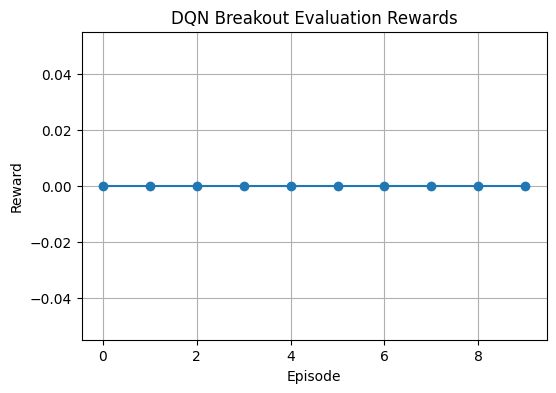

In [9]:
plt.figure(figsize=(6,4))
plt.title("DQN Breakout Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores, marker='o')
plt.grid()
plt.show()
